In [2]:
import datasets
import pickle
from utils import get_real_p, get_real_q, get_k
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import os

In [3]:
hanna = datasets.load_dataset("xxx")['train'].to_pandas()
meva = datasets.load_dataset("xxx")['train'].to_pandas()
summeval = datasets.load_dataset("xxx")['train'].to_pandas()
llmbar = datasets.load_dataset("xxx")['train'].to_pandas()
llmeval2 = datasets.load_dataset("xxx")['train'].to_pandas()
mtbench = datasets.load_dataset("xxx")['train'].to_pandas()
faireval = datasets.load_dataset("xxx")['train'].to_pandas()

# postprocessing
hanna = hanna.replace('w_gpt-3.5-turbo-0125', 'w_gpt-3.5-turbo-0125-score-only')
hanna = hanna.replace('w_gpt3.5_rate_explain', 'w_gpt-3.5-turbo-0125-rate-explain')

# filter hanna and meva to 1vn, summeval is already 1vn
hanna_baseline = 'GPT-2'
hanna = hanna[(hanna['generator_1'] == hanna_baseline) | (hanna['generator_2'] == hanna_baseline)]
meva_baseline = 'gpt'
meva = meva[(meva['generator_1'] == meva_baseline) | (meva['generator_2'] == meva_baseline)]

all_dfs = {'Hanna': hanna, 'Meva': meva, 'SummEval': summeval, 'LLMBar': llmbar, 'LLMEval2': llmeval2, 'MTBench': mtbench, 'FairEval': faireval}
all_non_inst_dfs = {'Hanna': hanna, 'Meva': meva, 'SummEval': summeval}
baseline_model_map = {'Hanna': hanna_baseline, 'Meva': meva_baseline, 'SummEval': 'GPT-2', 'LLMBar': 'correct', 'LLMEval2': 'correct', 'MTBench': 'correct', 'FairEval': 'correct'}
aggregated = pd.concat(all_dfs.values(), ignore_index=True)
aggregated_non_inst = pd.concat(all_non_inst_dfs.values(), ignore_index=True)

In [8]:
# Process logs
def parse_results(dirs, name, df=None, nvn=False):
    results_dir = {'generator_1': [], 'generator_2': [], '|Mean - p|': [], '|Mode - p|': [], '|k - p|': [], 'mean': [], 'mode': []}
    baseline_model = baseline_model_map[name]
    for d in dirs:
        if not os.path.exists(d):
            print(f'{d} does not exist')
            continue
        for f in os.listdir(d):
            if f.endswith('.pkl'):
                generator_1, generator_2 = f.split('.')[0].split('___')
                if not nvn:
                    if generator_1 != baseline_model and generator_2 != baseline_model:
                        continue
                results_dir['generator_1'].append(generator_1)
                results_dir['generator_2'].append(generator_2)
                result = pickle.load(open(f'{d}/{f}', 'rb'))
                results_dir['|Mean - p|'].append(abs(result.p_mean - result.true_p))
                results_dir['|Mode - p|'].append(abs(result.p_mode - result.true_p))
                results_dir['mean'].append(result.p_mean)
                results_dir['mode'].append(result.p_mode)
                # In in-dist trials, k is calculated on voting matrix, here we calculate k on the entire dataset
                # if df is not None:
                #     results_dir['|k - p|'].append(abs(get_k(df) - get_real_p(df)))
                # else:
                results_dir['|k - p|'].append(abs(result.k - result.true_p))
    results_dir['generator_1'].append('mean')
    results_dir['generator_2'].append('mean')
    results_dir['|Mean - p|'].append(np.mean(results_dir['|Mean - p|']))
    results_dir['|Mode - p|'].append(np.mean(results_dir['|Mode - p|']))
    results_dir['|k - p|'].append(np.mean(results_dir['|k - p|']))
    results_dir['mean'].append(np.mean(results_dir['mean']))
    results_dir['mode'].append(np.mean(results_dir['mode']))
    results_df = pd.DataFrame(results_dir)
    return results_df

In [12]:
import pathlib

def prepare_in_dist_error_curve(name, df, parse_path, no_path=None, ood_path=None, method='bwrs'):
    mean_errs, mode_errs, k_errs = [], [], []
    ood_mean_errs, ood_mode_errs = [], []
    no_mean_errs, no_mode_errs, no_k_errs = [], [], []
    x = []
    iter_num = 0
    multiple_iterations = any(['iteration' in d for d in os.listdir(parse_path)])
    file_name = "in_dist_*.*/" if method == 'bwrs' else "gold_labels_*.*/"
    if multiple_iterations:
        for iter_dir in os.listdir(parse_path):
            # in-dist results
            iter_num += 1
            paths = pathlib.Path(f'{parse_path}/{iter_dir}/plots/{name}-{method}').glob(file_name)
            for path in sorted(paths):
                # print(f'Loading {path}')
                results_df = parse_results([str(path)], name, df)
                mean_errs.append(results_df.loc[results_df['generator_1'] == 'mean', '|Mean - p|'].values.item())
                mode_errs.append(results_df.loc[results_df['generator_1'] == 'mean', '|Mode - p|'].values.item())
                k_errs.append(results_df.loc[results_df['generator_1'] == 'mean', '|k - p|'].values.item())
                d = re.search('\d+\.\d+', str(path))
                if d is not None:
                    x.append(float(d.group()))
        if no_path is not None:
            # no prior results
            for iter_dir in os.listdir(no_path):
                results_df = parse_results([f'{no_path}/{iter_dir}/plots/{name}-{method}/no_prior'], name)
                no_mean_errs.append(results_df.loc[results_df['generator_1'] == 'mean', '|Mean - p|'].values.item())
                no_mode_errs.append(results_df.loc[results_df['generator_1'] == 'mean', '|Mode - p|'].values.item())
        if ood_path is not None:
            ood_iter_num = 0
            for iter_dir in os.listdir(ood_path):
                # ood results
                ood_iter_num += 1
                # print(f'Loading ood_prior')
                results_df = parse_results([f'{ood_path}/{iter_dir}/plots/{name}-{method}/ood_prior'], name)
                ood_mean_errs.append(results_df.loc[results_df['generator_1'] == 'mean', '|Mean - p|'].values.item())
                ood_mode_errs.append(results_df.loc[results_df['generator_1'] == 'mean', '|Mode - p|'].values.item())
            # assert iter_num == ood_iter_num, f'Number of in-dist and ood iterations do not match ({iter_num} vs {ood_iter_num})'
    else:
        iter_num = 1
        # in-dist results
        paths = list(pathlib.Path(f'{parse_path}/plots/{name}-{method}').glob(file_name))
        for path in sorted(paths):
            # print(f'Loading {path}')
            results_df = parse_results([str(path)], name, df)
            mean_errs.append(results_df.loc[results_df['generator_1'] == 'mean', '|Mean - p|'].values.item())
            mode_errs.append(results_df.loc[results_df['generator_1'] == 'mean', '|Mode - p|'].values.item())
            k_errs.append(results_df.loc[results_df['generator_1'] == 'mean', '|k - p|'].values.item())
        if no_path is not None:
            # no prior results
            # print(f'Loading no_prior')
            results_df = parse_results([f'{no_path}/plots/{name}-{method}/no_prior'], name)
            no_mean_errs.append(results_df.loc[results_df['generator_1'] == 'mean', '|Mean - p|'].values.item())
            no_mode_errs.append(results_df.loc[results_df['generator_1'] == 'mean', '|Mode - p|'].values.item())
        if ood_path is not None:
            # ood results
            # print(f'Loading ood_prior')
            results_df = parse_results([f'{ood_path}/plots/{name}-{method}/ood_prior'], name)
            ood_mean_errs.append(results_df.loc[results_df['generator_1'] == 'mean', '|Mean - p|'].values.item())
            ood_mode_errs.append(results_df.loc[results_df['generator_1'] == 'mean', '|Mode - p|'].values.item())

    # seaborn
    mean_errs = np.array(mean_errs).reshape(1, -1)
    mode_errs = np.array(mode_errs).reshape(1, -1)
    k_errs = np.array(k_errs).reshape(1, -1)
    df = pd.DataFrame(mean_errs, columns=x)
    df['Estimator'] = 'mean'
    df2 = pd.DataFrame(mode_errs, columns=x)
    df2['Estimator'] = 'mode'
    df3 = pd.DataFrame(k_errs, columns=x)
    df3['Estimator'] = 'k'
    df = pd.concat([df, df2, df3])
    df = df.melt(id_vars='Estimator', var_name='prior data ratio', value_name='Error')
    if no_path is not None:
        no_mean_errs = np.array(no_mean_errs).reshape(1, -1)
        no_mode_errs = np.array(no_mode_errs).reshape(1, -1)
        no_x = np.zeros(no_mean_errs.shape[1])
        df4 = pd.DataFrame(no_mean_errs, columns=no_x)
        df4['Estimator'] = 'mean'
        df5 = pd.DataFrame(no_mode_errs, columns=no_x)
        df5['Estimator'] = 'mode'
        df4 = df4.melt(id_vars='Estimator', var_name='prior data ratio', value_name='Error')
        df5 = df5.melt(id_vars='Estimator', var_name='prior data ratio', value_name='Error')
        df = pd.concat([df, df4, df5])
    if ood_path is not None:
        ood_x = np.tile(np.arange(0.1, 1.1, 0.1), ood_iter_num)
        ood_mean_errs = np.repeat(ood_mean_errs, 10).reshape(1, -1)
        ood_mode_errs = np.repeat(ood_mode_errs, 10).reshape(1, -1)
        df6 = pd.DataFrame(ood_mean_errs, columns=ood_x)
        df6['Estimator'] = 'ood_prior_mean'
        df7 = pd.DataFrame(ood_mode_errs, columns=ood_x)
        df7['Estimator'] = 'ood_prior_mode'
        # df = df.melt(id_vars='Estimator', var_name='prior data ratio', value_name='Error')
        df6 = df6.melt(id_vars='Estimator', var_name='prior data ratio', value_name='Error')
        df7 = df7.melt(id_vars='Estimator', var_name='prior data ratio', value_name='Error')
        df = pd.concat([df, df6, df7])
    df.reset_index(drop=True, inplace=True)
    df['dataset'] = name
    # sns.relplot(data=df, x='prior data ratio', y='Error', hue='Estimator', kind='line', height=8.27, aspect=11.7/8.27, errorbar='sd')
    # plt.title(title)
    # plt.show()
    return df

def plot_all_in_dist_error_curves(in_dist_dirs, no_root=None, ood_root=None, method='bwrs'):
    plot_dfs = []
    for in_dist_root in in_dist_dirs:
        for name, df in all_dfs.items():
            do_no_prior = method == 'bayds' and no_root is not None
            do_ood = ood_root is not None and name in all_non_inst_dfs.keys()
            if do_no_prior and do_ood:
                plot_dfs.append(prepare_in_dist_error_curve(name, df, in_dist_root, no_root, ood_root, method))
            elif do_no_prior:
                plot_dfs.append(prepare_in_dist_error_curve(name, df, in_dist_root, no_root, None, method))
            elif do_ood:
                plot_dfs.append(prepare_in_dist_error_curve(name, df, in_dist_root, None, ood_root, method))
            else:
                plot_dfs.append(prepare_in_dist_error_curve(name, df, in_dist_root, None, None, method))
    g = sns.FacetGrid(pd.concat(plot_dfs), col='dataset', hue='Estimator', col_wrap=3, height=3.5, aspect=1).map(sns.lineplot, 'prior data ratio', 'Error').add_legend()
    plt.subplots_adjust(top=0.9)  # Adjust the top to make space for the title if necessary
    g.fig.suptitle('BWRS', fontsize=16)  # Set a global title for the figure
    # Show the plot
    plt.show()

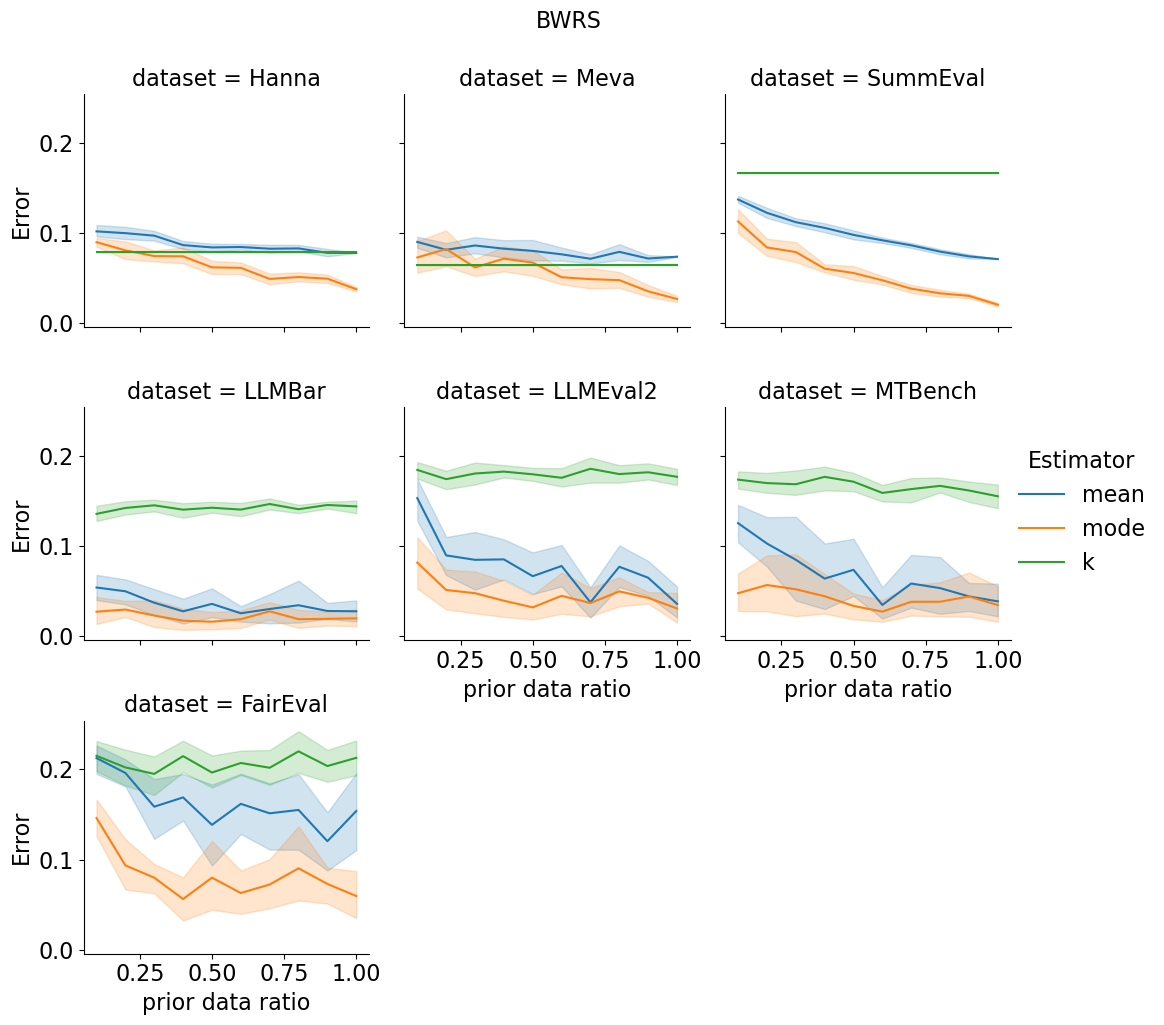

In [13]:
plot_all_in_dist_error_curves(['results_repeat_6_2_5_runs'])
# plot_all_in_dist_error_curves(['results_bds_in_dist_repeat_all'], method='bayds')
# plot_all_in_dist_curves('results-5-28-in-dist/plots', 'results_repeat_5_runs_5_23/iteration_1/plots', 'bayds')

In [16]:
def parse_repeat_results(dir, df, name, method, prior):
    dfs = []
    for iter_dir in os.listdir(dir):
        results_df = parse_results([f'{dir}/{iter_dir}/plots/{name}-{method}/{prior}'], name, df)
        dfs.append(results_df)
    concat_df = pd.concat(dfs, ignore_index=True)
    mean_df = concat_df.groupby(['generator_1', 'generator_2']).mean().reset_index()
    std_df = concat_df.groupby(['generator_1', 'generator_2']).std().reset_index()
    return mean_df, std_df

In [17]:
parse_repeat_results('results', hanna, 'Hanna', 'bayds', 'no_prior')

(  generator_1     generator_2  |Mean - p|  |Mode - p|   |k - p|      mean  \
 0       GPT-2  BertGeneration    0.041567    0.013848  0.057292  0.322817   
 1       GPT-2            CTRL    0.589260    0.604154  0.095486  0.839260   
 2       GPT-2          Fusion    0.026303    0.056376  0.026042  0.838803   
 3       GPT-2             GPT    0.163620    0.168133  0.133681  0.486537   
 4       GPT-2     GPT-2 (tag)    0.007537    0.005586  0.038194  0.455454   
 5       GPT-2            HINT    0.041440    0.027675  0.012153  0.875227   
 6       GPT-2         RoBERTa    0.037396    0.033142  0.036458  0.587604   
 7       GPT-2          TD-VAE    0.060431    0.068894  0.107639  0.716681   
 8       GPT-2           XLNet    0.197886    0.211763  0.206597  0.906219   
 9        mean            mean    0.129493    0.132175  0.079282  0.669845   
 
        mode  
 0  0.295098  
 1  0.854154  
 2  0.868876  
 3  0.491050  
 4  0.450784  
 5  0.888992  
 6  0.591858  
 7  0.725144  
 8  0